In [57]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps
from utils.combine_tools import apply_qc
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
warnings.filterwarnings('ignore')

%matplotlib inline

# Load data

In [58]:
criteria_name = 'beh_all'

In [59]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 17847 -> 8148 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8148 -> 5771 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5771 -> 5748 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 5748 -> 4224 units passed
Applying items for in_df: [True]
 - in_df: 4224 -> 4224 units passed
Applying conditional bounds for y_loc
 - y_loc: 4224 -> 2970 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 306
Number of non-opto units after filtering: 2970


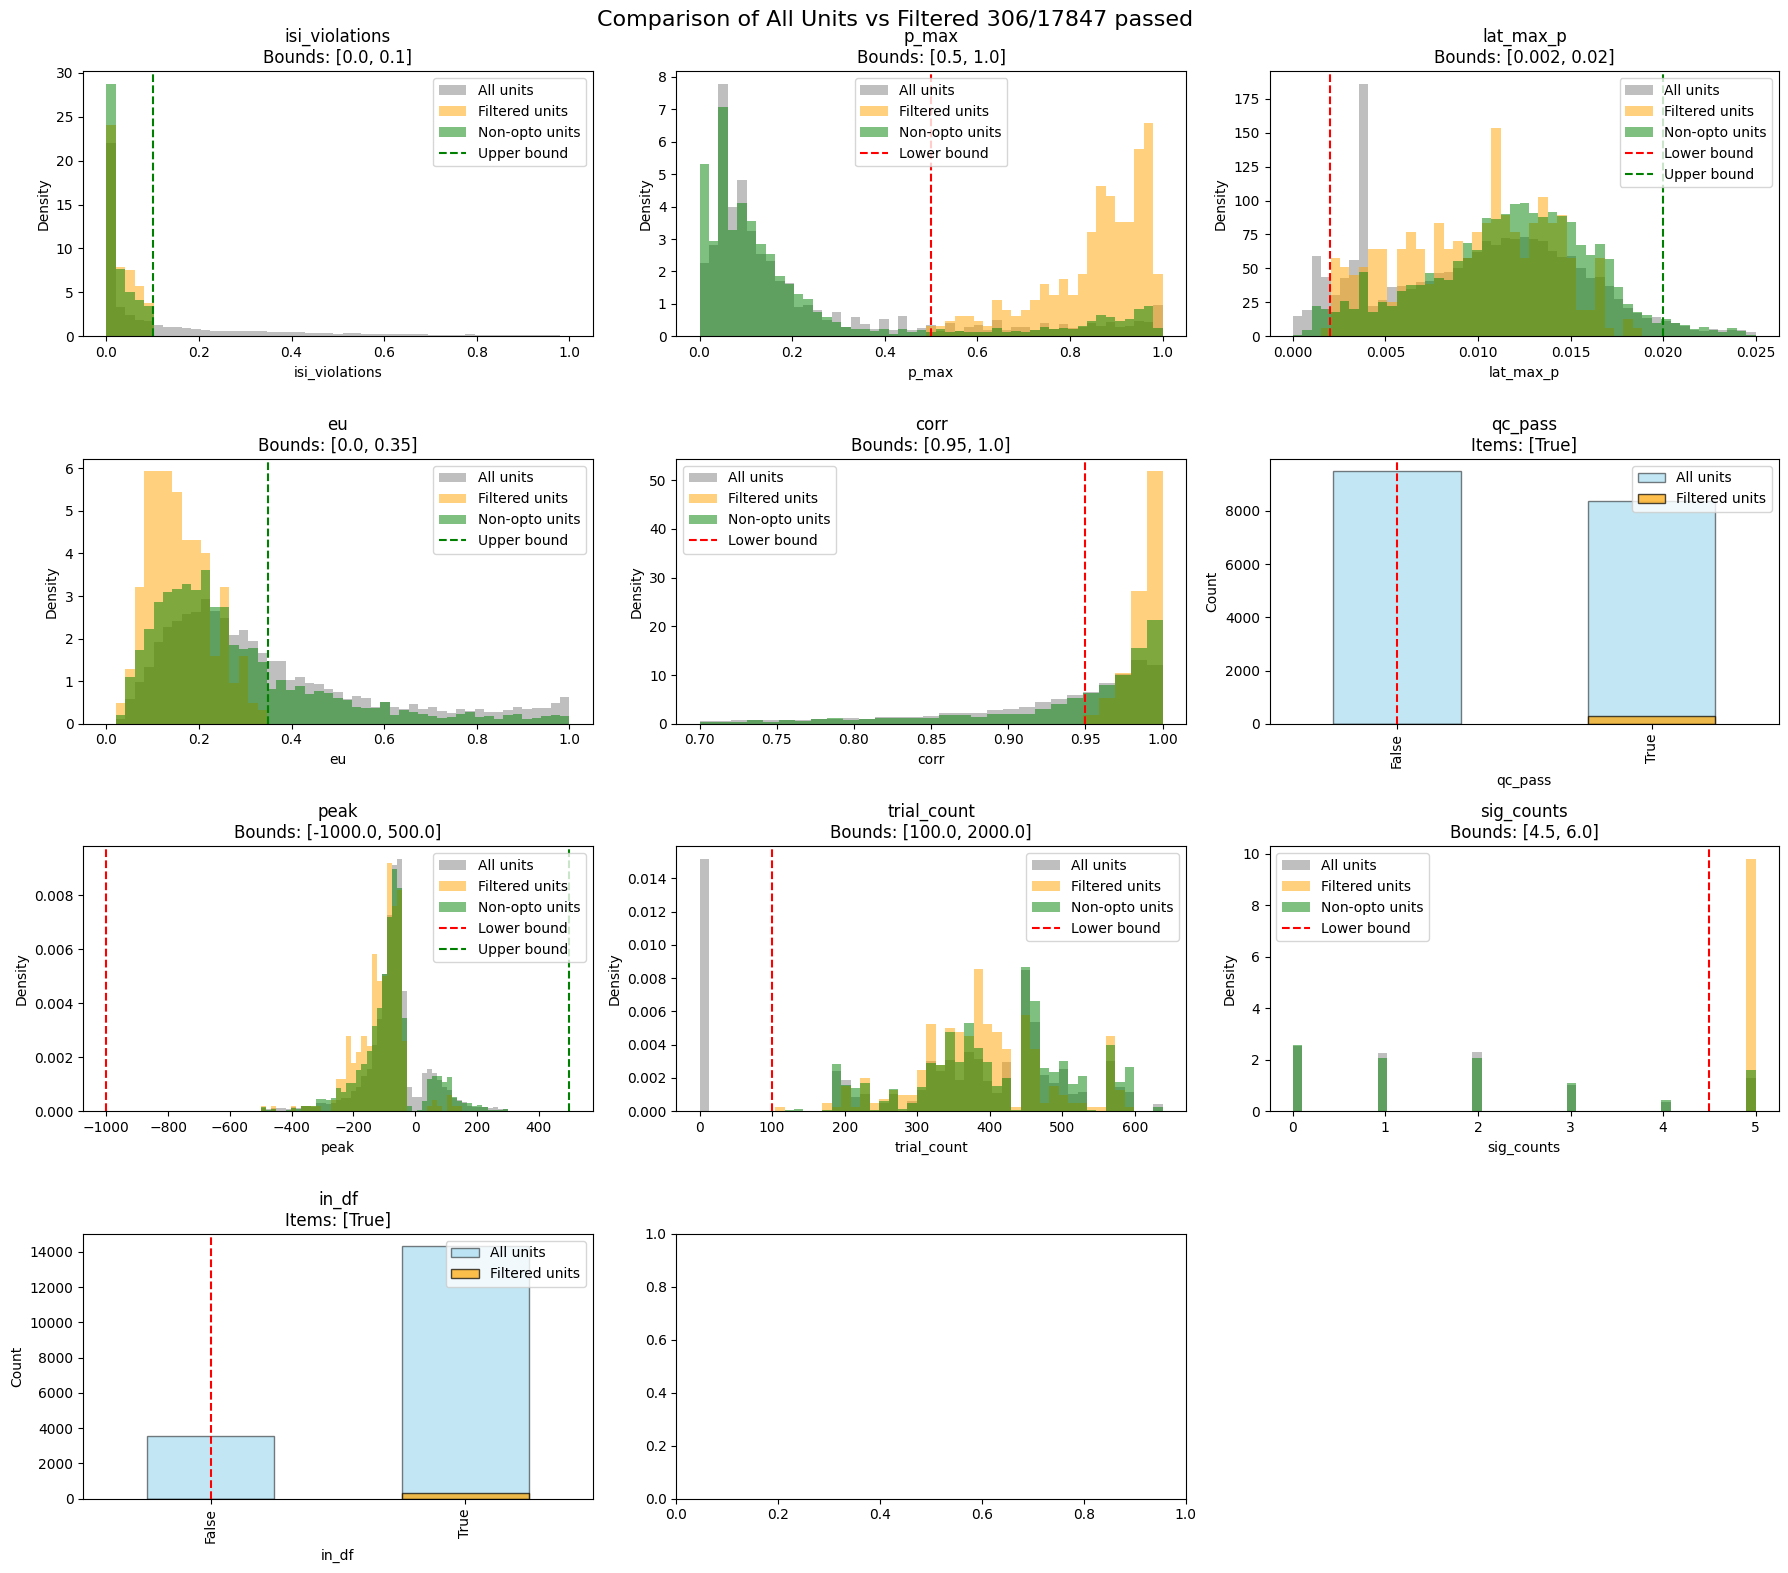

In [60]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

In [61]:
model_combined = pd.read_csv(os.path.join(beh_folder, 'figures_in_generation', f'model_combined_{criteria_name}.csv'), index_col=0)
model_combined['theta'] = model_combined['theta'] - 0.5

# Scatter and polar

In [62]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'l'
verion = 'mc'  # 'ori' or 'mc'

curr_p_int = model_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = model_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 


curr_coefs_outcome = model_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = model_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = model_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = model_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = model_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

# curr_T_outcome = all_Tm[:, outcome_ind]  # get the T-statistics for the reward outcome
# curr_T_q = all_Tm[:, q_ind]  # get the T-statistics for the Qchosen
# curr_p_outcome = all_pm[:, outcome_ind]  # get the p-values for the reward outcome


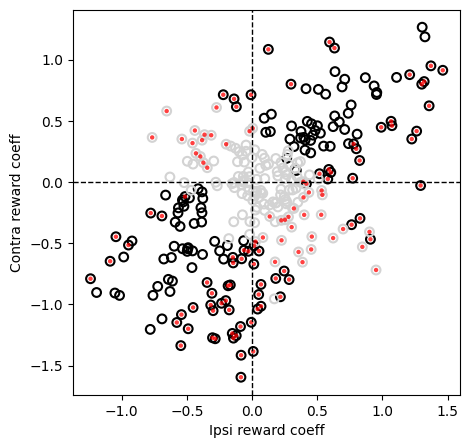

<Figure size 640x480 with 0 Axes>

In [63]:
# compare ipsi vs contra responses
ipsi_reward_coeff = curr_coefs_outcome + curr_coefs_int
contra_reward_coeff = curr_coefs_outcome - curr_coefs_int

# scatter
plt.figure(figsize=(5, 5))
plt.scatter(ipsi_reward_coeff[curr_p_outcome<0.05], contra_reward_coeff[curr_p_outcome<0.05], 
            alpha=1, edgecolors='k', color='none', s=40, linewidths=1.5)
plt.scatter(ipsi_reward_coeff[curr_p_outcome>=0.05], contra_reward_coeff[curr_p_outcome>=0.05],
            alpha=1, edgecolors='lightgray', color='none', s=40, linewidths=1.5)
mask = curr_p_int<0.05
plt.scatter(ipsi_reward_coeff[mask], contra_reward_coeff[mask],
            alpha=0.75, edgecolors='none', color='red', s=10)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Ipsi reward coeff')
plt.ylabel('Contra reward coeff')
plt.show()
plt.savefig(os.path.join(beh_folder, f'ipsi_vs_contra_reward_coeff_{criteria_name}.pdf'), bbox_inches='tight')

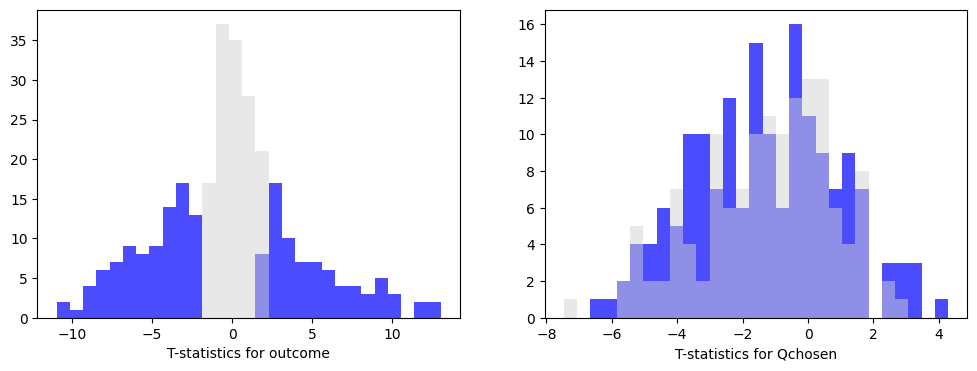

In [64]:
# histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
bins = np.linspace(np.nanmin(curr_T_outcome)-0.01, np.nanmax(curr_T_outcome)+0.01, 30)
plt.hist(curr_T_outcome[curr_p_outcome<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
plt.hist(curr_T_outcome[curr_p_outcome>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
plt.xlabel('T-statistics for outcome')

plt.subplot(1, 2, 2)
bins = np.linspace(np.nanmin(curr_T_q)-0.01, np.nanmax(curr_T_q)+0.01, 30)
plt.hist(curr_T_q[curr_p_outcome<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
plt.hist(curr_T_q[curr_p_outcome>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
plt.xlabel('T-statistics for Qchosen')
plt.savefig(os.path.join(beh_folder, f'T_statistics_outcome_Qchosen_focus_wind_{criteria_name}.pdf'), bbox_inches='tight')


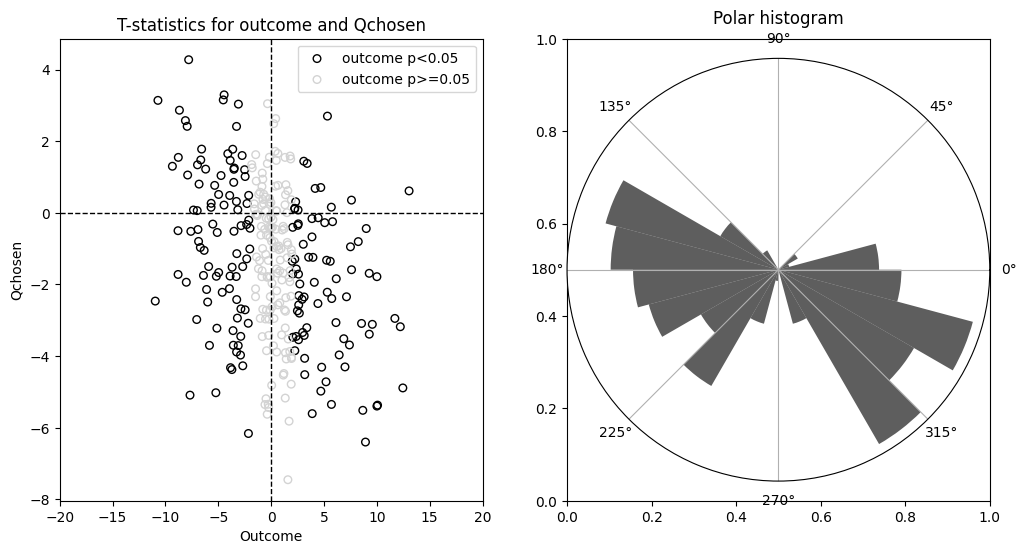

In [76]:
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(curr_T_outcome[curr_p_outcome<0.05], curr_T_q[curr_p_outcome<0.05], color='none', edgecolors='k', s=30, label = 'outcome p<0.05')
axes[0].scatter(curr_T_outcome[curr_p_outcome>=0.05], curr_T_q[curr_p_outcome>=0.05], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()
axes[0].set_xlim([-20, 20])

# polar
thresh = 0.05
all_vec = np.column_stack((curr_coefs_outcome[curr_p_outcome<thresh], curr_coefs_q[curr_p_outcome<thresh]))  # combine the coefficients for the reward outcome and Qchosen
all_vec = all_vec.astype(float)
# Convert Cartesian coordinates to polar coordinates
theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
# Define histogram edges (bins) from -π to π
edges = np.linspace(-np.pi, np.pi, 4*6+1)
# Create polar histogram
axes[1] = fig.add_subplot(122, polar=True)
axes[1].hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=False)
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
# plt.suptitle('Outcome and Qchosen coefficients', fontsize=16)
plt.savefig(os.path.join(beh_folder, f'Summary_outcome_Qchosen_coeffs_{criteria_name}.pdf'), bbox_inches='tight')

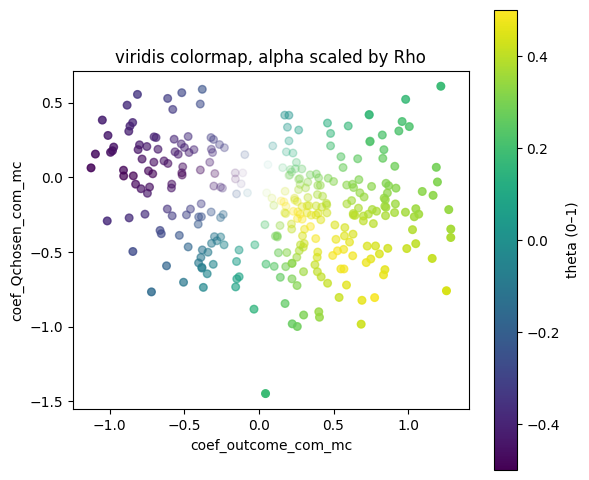

In [102]:
import matplotlib.pyplot as plt
import numpy as np

theta = model_combined['theta'].values

# Define viridis colormap and normalization
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-0.5, vmax=0.5)

# Alpha = distance from 0.5 → scaled to 0–1 range
alpha_scale = np.sqrt(model_combined['rho'])
alpha_scale = np.clip(alpha_scale, 0, 1.2)
alpha_scale = (alpha_scale - np.min(alpha_scale)) / (np.max(alpha_scale) - np.min(alpha_scale))

# Map θ → viridis colors, then inject alpha per point
colors = cmap(norm(theta))
colors[:, -1] = alpha_scale  # assign alpha channel

# Create scatter using facecolors directly (so alpha is preserved)
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    model_combined['coef_outcome_com_mc'],
    model_combined['coef_Qchosen_com_mc'],
    facecolors=colors,
    edgecolors=None,
    s=30,
    marker='o'
)

# Create a standalone ScalarMappable for the colorbar
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# Attach colorbar to this axis
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("theta (0–1)")

ax.set_xlabel("coef_outcome_com_mc")
ax.set_ylabel("coef_Qchosen_com_mc")
ax.set_title("viridis colormap, alpha scaled by Rho")
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()


(array([ 6., 10., 25., 38., 42., 56., 62., 39., 21.,  7.]),
 array([0.2757173 , 0.36929753, 0.46287775, 0.55645798, 0.6500382 ,
        0.74361842, 0.83719865, 0.93077887, 1.0243591 , 1.11793932,
        1.21151955]),
 <BarContainer object of 10 artists>)

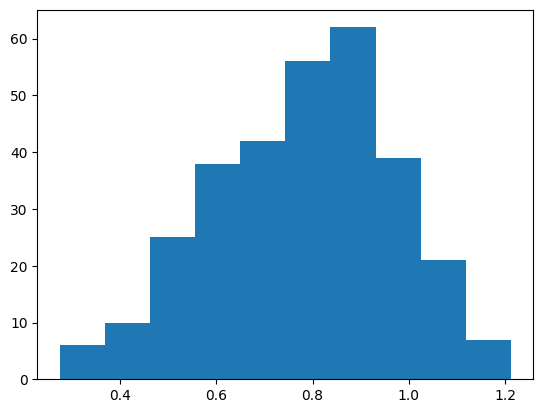

In [67]:
plt.hist(np.sqrt(model_combined['rho']))

In [68]:
# load
# model_combined = pd.read_csv(os.path.join(beh_folder, f'model_combined_{criteria_name}.csv'))
# model_combined_anti = pd.read_csv('/root/capsule/scratch/combined/beh_plots/beh_all_anti/model_combined_beh_all_anti.csv')


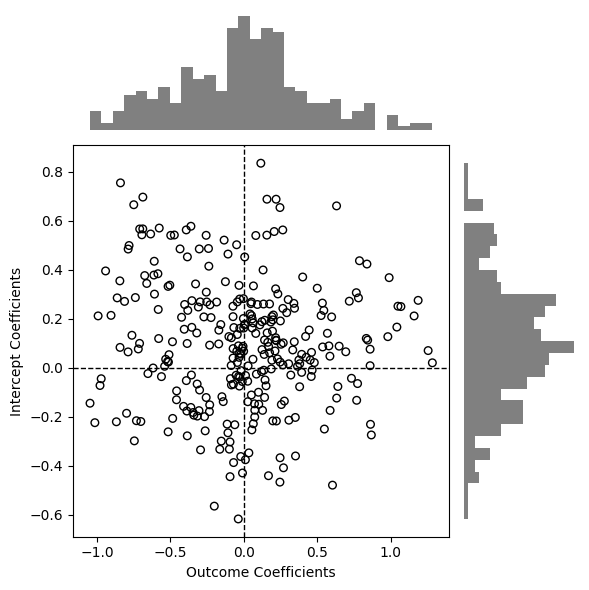

In [69]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'l'
verion = 'mc'  # 'ori' or 'mc'
c_or_t = 'T'

curr_p_int = model_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = model_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 


curr_coefs_outcome = model_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = model_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = model_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = model_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = model_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome


# curr_T_outcome = all_Tm[:, outcome_ind]  # get the T-statistics for the reward outcome
# curr_T_q = all_Tm[:, q_ind]  # get the T-statistics for the Qchosen
# curr_p_outcome = all_pm[:, outcome_ind]  # get the p-values for the reward outcome

# curr_T_outcome = model_combined['outcome_T'].values  # get the T-statistics for the reward outcome
# curr_T_q = model_combined['Qchosen_T'].values  # get the T-statistics for the Qchosen
# curr_p_outcome = model_combined['outcome_p'].values  # get the p-values for the reward outcome

# curr_coefs_outcome = model_combined['outcome_coef'].values  # get the coefficients for the reward outcome
# curr_coefs_q = model_combined['Qchosen_coef'].values  # get the coefficients for the Qchosen
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Example data
# curr_coefs_outcome = ...
# curr_coefs_int = ...

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_coefs_outcome, curr_coefs_int, color='none', edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Intercept Coefficients')

# Histogram for X-axis
ax_histx.hist(curr_coefs_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_coefs_int, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


# plot behavior coeffs in space

In [70]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)

features_beh = model_combined.columns.tolist()
features_beh.remove('session')
features_beh.remove('unit_id')
# drop all features ending with '_p'
features_beh = [f for f in features_beh if not f.startswith('p_') and not f.endswith('_p')]

In [93]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import os

p_curr = model_combined['p_outcome_com_mc'].values
mask = p_curr < 1
features_to_plot = ['t_outcome|(|t_outcome| + |t_Q|)', 'theta_e', 'theta_l', 'theta_com', 'outcome_ipsi', 'coef_outcome|(|coef_outcome| + |coef_Q|)']
# features_to_plot = features_beh
versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((model_combined[f'coef_outcome_{version}_mc'], model_combined[f'coef_Qchosen_{version}_ori']))  # combine the coefficients for the reward outcome and Qchosen]))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1 = -(1/4)*np.pi
    bound_2 = np.pi
    bound_3 = -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr-bound_1)/(bound_2-bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1-angle_curr)/(bound_1-bound_3)
    theta_scaled_dis_all = 1-theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all


model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
model_combined['outcome_contra'] = model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']

fig, axes = plt.subplots(len(features_to_plot), 4, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- 3D anatomical points ---
ccfs = combined_tagged_units_filtered[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for ind, feature in enumerate(features_to_plot):
    color = model_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize colors to 0–1 ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.min(color_reg))/(amp_cut - np.min(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list('white_red', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Histogram of feature values ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(model_combined[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label = 'max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label = 'min')
    ax_hist.legend()

    # === Compute alpha scaling from rho ===
    alpha_scale = model_combined['rho'].values[mask]
    alpha_scale = np.sqrt(alpha_scale)               # soften scaling
    alpha_scale = np.clip(alpha_scale, 0.2, 0.8)     # prevent extremes

    # === Sort and filter ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === Precompute RGBA facecolors ===
    rgba_colors = custom_cmap(color_reg_plot)
    rgba_colors[:, -1] = alpha_scale_plot  # inject alpha per point

    # === 2D plane projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # background mesh outline
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='k', alpha=0.4, s=0.05, edgecolors='none'
        )

        # scatter the points (alpha-scaled)
        sc = ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors=rgba_colors,
            edgecolors='none',
            s=25
        )

        if plane == 'hor':
            ax.set_title(feature)
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(os.path.join(beh_folder, f'model_combined_spatial_{criteria_name}.{ext}'),
                bbox_inches='tight', dpi=300)
plt.close()


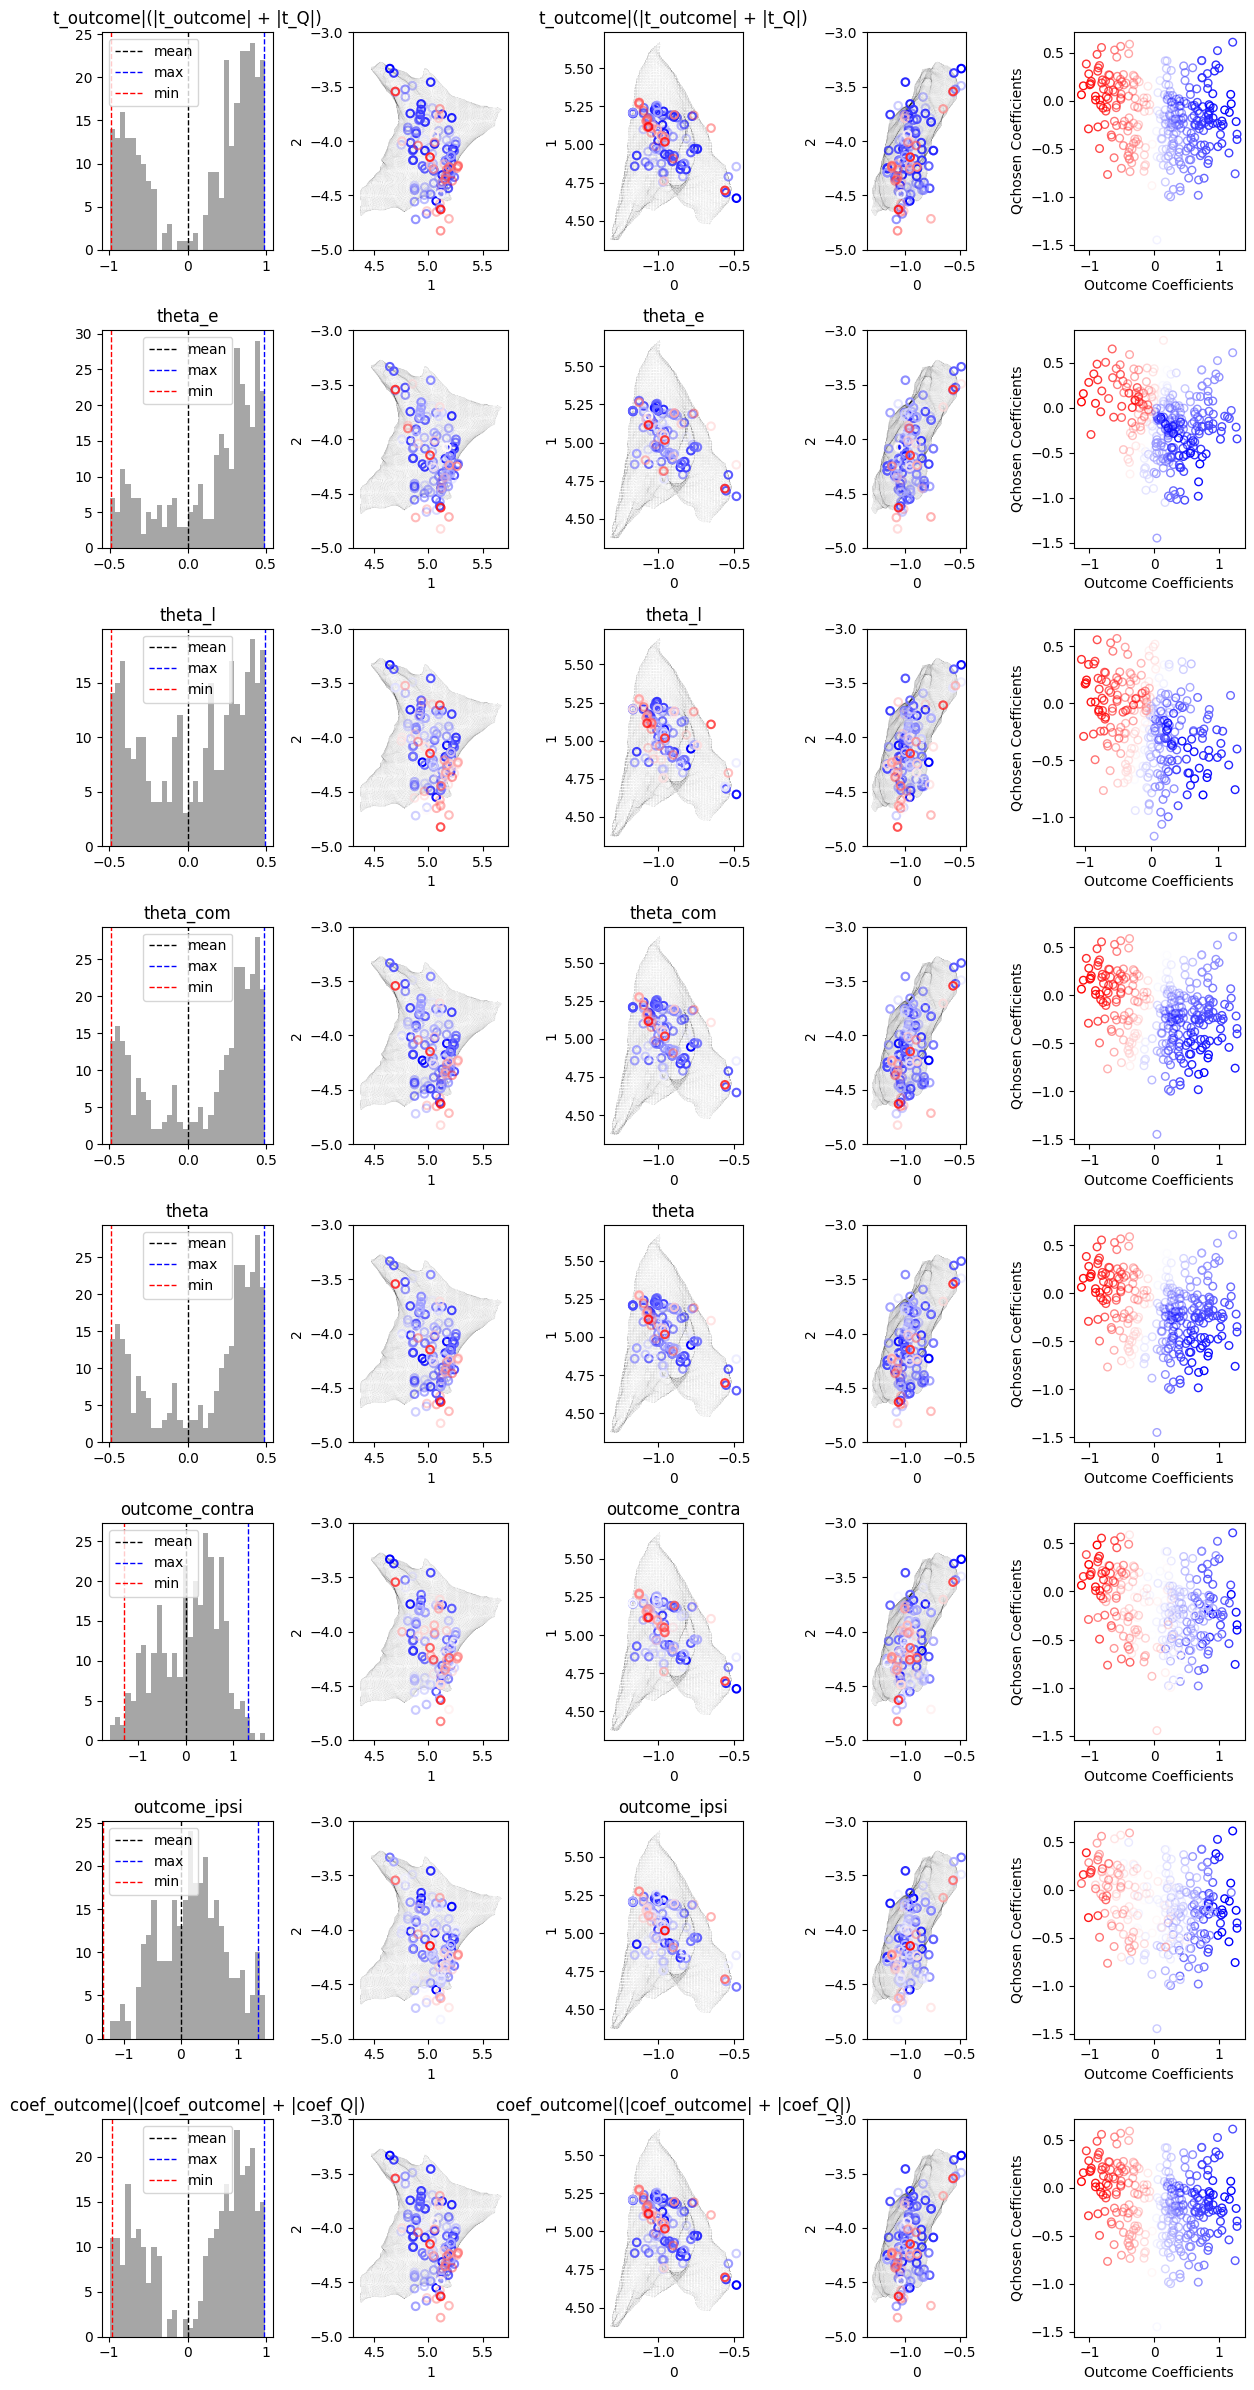

In [116]:
p_curr = model_combined['p_outcome_com_mc'].values
mask = p_curr < 1
features_to_plot = [
    't_outcome|(|t_outcome| + |t_Q|)',
    'theta_e', 'theta_l', 'theta_com', 'theta', 'outcome_contra',
    'outcome_ipsi', 'coef_outcome|(|coef_outcome| + |coef_Q|)'
]
# features_to_plot = ['theta']

versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((
        model_combined[f'coef_outcome_{version}_mc'],
        model_combined[f'coef_Qchosen_{version}_ori']
    ))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1, bound_2, bound_3 = -(1 / 4) * np.pi, np.pi, -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr - bound_1) / (bound_2 - bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1 - angle_curr) / (bound_1 - bound_3)
    theta_scaled_dis_all = 1 - theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all

# derived features
model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = (
    model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
)
model_combined['outcome_contra'] = (
    model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']
)

# --- setup figure grid ---
fig, axes = plt.subplots(len(features_to_plot), 5, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- anatomical coordinates ---
ccfs = combined_tagged_units_filtered[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for ind, feature in enumerate(features_to_plot):
    color = model_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === normalize color range ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red',
            [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.min(color_reg)) / (amp_cut - np.min(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        custom_cmap = LinearSegmentedColormap.from_list(
            'white_red', [(0.0, 'white'), (1.0, 'red')]
        )

    color_reg[np.isnan(color_reg)] = 0.5

    # === histogram ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(model_combined[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label='max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label='min')
    ax_hist.legend()

    # === alpha scaling (rho) ===
    alpha_scale = model_combined['rho'].values[mask]
    # alpha_scale = np.sqrt(alpha_scale)
    alpha_scale = np.clip(alpha_scale, 0.2, 1)

    # === sorting ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === map color to edge RGBA ===
    edge_rgba = custom_cmap(color_reg_plot)
    edge_rgba[:, -1] = alpha_scale_plot  # add per-point alpha

    # === 2D projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='k', alpha=0.3, s=0.05, edgecolors='none'
        )

        # main scatter: edge gradient only
        ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors='none',
            edgecolors=edge_rgba,
            linewidths=1.5,
            s=30
        )

        if plane == 'hor':
            ax.set_title(feature)
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])
    
    if len(feature.split("_"))>=2:
        if feature.split("_")[1] in ['e', 'l', 'com']:
            period = feature.split("_")[1]
        else:
            period = 'com'
    else:
        period = 'com'
    ax = axes[ind, -1]
    ax.scatter(
        model_combined[f'coef_outcome_{period}_mc'][mask][sort_ind],
        model_combined[f'coef_Qchosen_{period}_mc'][mask][sort_ind],
        color='none', edgecolors=edge_rgba, s=30
    )
    ax.set_xlabel('Outcome Coefficients')
    ax.set_ylabel('Qchosen Coefficients')

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(
        os.path.join(beh_folder, f'model_combined_spatial_edge_{criteria_name}.{ext}'),
        bbox_inches='tight', dpi=300
    )
# plt.close()


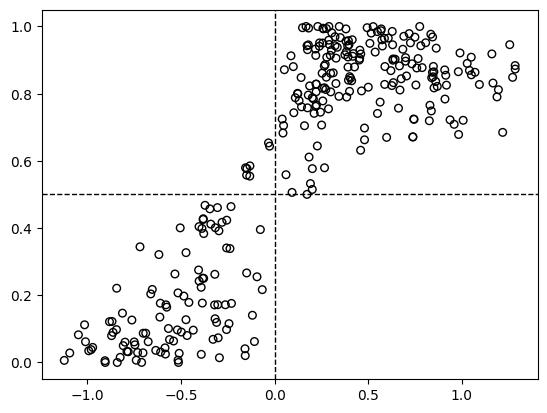

In [110]:
plt.scatter(model_combined['coef_outcome_com_mc'][mask][sort_ind], color_reg_plot, color='none', edgecolors='k', s=30)
plt.axhline(0.5, color='k', linestyle='--', linewidth=1)
plt.axvline(0, color='k', linestyle='--', linewidth=1)

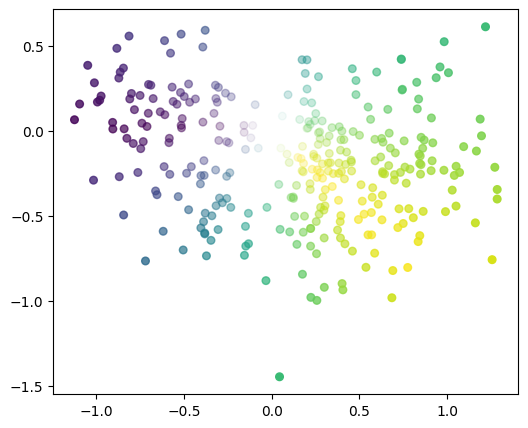

In [107]:
# Define viridis colormap and normalization
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-0.5, vmax=0.5)

# Alpha = distance from 0.5 → scaled to 0–1 range
alpha_scale = np.sqrt(model_combined['rho'])
alpha_scale = np.clip(alpha_scale, 0, 1.2)
alpha_scale = (alpha_scale - np.min(alpha_scale)) / (np.max(alpha_scale) - np.min(alpha_scale))

# === sorting ===
sort_ind = np.argsort(color_reg[mask])[::-1]
ccfs_plot = ccfs[mask][sort_ind]
color_reg_plot = color_reg[mask][sort_ind]
alpha_scale_plot = alpha_scale[sort_ind]

# Map θ → viridis colors, then inject alpha per point
colors = cmap(norm(model_combined['theta'].values))
colors[:, -1] = alpha_scale  # assign alpha channel

# Create scatter using facecolors directly (so alpha is preserved)
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    model_combined['coef_outcome_com_mc'],
    model_combined['coef_Qchosen_com_mc'],
    facecolors=colors,
    edgecolors=None,
    s=30,
    marker='o'
)

In [81]:
import k3d
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os

# --- Prepare mask and derived features ---
p_curr = model_combined['p_outcome_com_mc'].values
mask = p_curr < 1
features_to_plot = ['t_outcome|(|t_outcome| + |t_Q|)', 'theta', 'test', 'T_outcome_com_ori']
features_to_plot = features_beh
model_combined['test'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)

# --- Anatomical coordinates ---
ccfs = combined_tagged_units_filtered[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml = 0
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for feature in features_to_plot:
    color = model_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize color range to [0, 1] ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.9)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list(
            'bwr_custom', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg)) / (amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list('wr_custom', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Alpha scaling (from rho) ===
    alpha_scale = model_combined['rho'].values[mask]
    alpha_scale = np.sqrt(alpha_scale)
    alpha_scale = np.clip(alpha_scale, 0.2, 0.9)

    # === Sort for proper rendering ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === Map to RGBA, inject alpha ===
    rgba = custom_cmap(color_reg_plot)
    rgba[:, -1] = alpha_scale_plot
    rgb = (rgba[:, :3] * 255).astype(np.uint32)
    colors = (rgb[:, 0] << 16) + (rgb[:, 1] << 8) + rgb[:, 2]

    # --- Create interactive K3D plot ---
    plt_3d = k3d.plot(
        camera_auto_fit=True,
        background_color=0x000000,
        grid_visible=False
    )

    # --- Optional: anatomical mesh if available ---
    if 'mesh_vertices_mm' in locals() and 'mesh' in locals():
        faces = np.array(mesh.faces).astype(np.uint32)
        plt_3d += k3d.mesh(
            mesh_vertices_mm.astype(np.float32),
            faces,
            color=0x888888,
            opacity=0.1
        )

    # # --- Scatter points with per-point alpha ---
    # pts = k3d.points(
    #     positions=ccfs_plot.astype(np.float32),
    #     colors=colors.astype(np.uint32),
    #     point_size=0.05,
    #     shader='3d',
    #     opacity=1.0
    # )

    for ind in range(len(ccfs_plot)):
        pt = k3d.points(
            positions=ccfs_plot[ind:ind+1].astype(np.float32),
            colors=np.array([colors[ind]]).astype(np.uint32),
            point_size=0.05,
            shader='3d',
            opacity=alpha_scale_plot[ind]
        )
        plt_3d += pt

    # --- Add colorbar (sample colormap directly) ---
    color_map_for_bar = np.array(
        [custom_cmap(i / 255)[:3] for i in range(256)],
        dtype=np.float32
    )

    # plt_3d += k3d.color_map.ColorMap(
    #     color_map=color_map_for_bar,
    #     color_range=[np.nanmin(color), np.nanmax(color)],
    #     label=feature,
    #     position_x=0.02,
    #     position_y=0.85,
    #     width=0.015,
    #     height=0.5
    # )

    # --- Save to HTML ---
    html_path = os.path.join(beh_folder, '3D_links',f'k3d_{feature}_3D.html')
    os.makedirs(os.path.dirname(html_path), exist_ok=True)
    with open(html_path, 'w') as f:
        f.write(plt_3d.get_snapshot())

    print(f"✅ Saved interactive plot: {html_path}")


✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_Qchosen_e_ori_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_outcome_e_ori_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ipsi_e_ori_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_outcome:ipsi_e_ori_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_amp_e_ori_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_Qchosen_l_ori_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_outcome_l_ori_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ipsi_l_ori_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_outcome:ipsi_l_ori_

In [73]:
combined_tagged_units_filtered[combined_tagged_units_filtered['y_loc']>3000]['session']

167    behavior_ZS059_2021-04-15_15-29-28
168    behavior_ZS059_2021-04-21_15-58-55
169    behavior_ZS059_2021-04-22_15-11-25
170    behavior_ZS059_2021-04-23_14-57-50
171    behavior_ZS060_2021-03-29_16-21-37
                      ...                
302    behavior_ZS062_2021-05-07_17-38-21
303    behavior_ZS062_2021-05-08_18-43-47
304    behavior_ZS062_2021-05-10_19-15-51
305    behavior_ZS062_2021-05-10_19-15-51
306    behavior_ZS062_2021-05-11_20-10-59
Name: session, Length: 81, dtype: object

In [40]:
np.where((ccfs[:,2]>-3.6) & (model_combined['test']<0))

(array([135]),)

In [41]:
combined_tagged_units_filtered.iloc[135]

session                             behavior_781166_2025-05-16_14-16-34
unit                                                                 72
qc_pass                                                            True
opto_tagged                                                       False
opto_tagging_pre                                                   True
opto_tagging_post                                                  True
anti                                                               True
in_df                                                              True
trial_count                                                         504
p_max                                                          0.860329
sig_counts                                                          5.0
p_mean                                                         0.841486
lat_max_p                                                      0.010931
isi_violations                                                 0

In [65]:
unit_tbl = get_unit_tbl('behavior_758017_2025-02-06_11-26-14', 'curated')

In [66]:
unit_tbl[unit_tbl['unit_id']==85]

,bl_max_p,p_max,p_mean,lat_max_p,lat_mean,euc_max_p,corr_max_p,opto_pass,amp,peak,...,mat_wf_raw_fake_aligned,peak_waveform_raw_fake,peak_waveform_raw_fake_aligned,amplitude_raw_fake,peak_raw_fake,loc_along_probe_x,x_ccf,y_ccf,z_ccf,loc_along_probe_y
80,0.15039,0.59961,0.50961,0.009292,0.009707,0.069197,0.994545,True,114.850676,-88.006195,...,"[[-3.5001306533813477, -3.5622751712799072, -3...","[-2.4130260944366455, -2.5767648220062256, -2....","[-3.1633596420288086, -3.1890900135040283, -3....",148.48259,-121.297562,2581.905082,-6.561614,10.467542,-2.272856,2581.905082


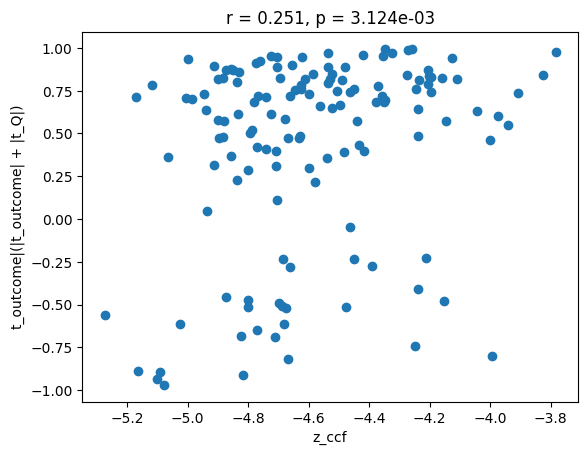

In [55]:
from scipy.stats import pearsonr
x_feature = 'z_ccf' 
y_feature = 't_outcome|(|t_outcome| + |t_Q|)'
if x_feature == 'x_ccf':
    x = np.abs(combined_tagged_units_filtered[x_feature] + bregma_points_mm[2])
else:
    x = combined_tagged_units_filtered[x_feature]
y = model_combined[y_feature]
z = combined_tagged_units_filtered['z_ccf']

# Remove NaNs from both x and y
mask = ~(np.isnan(x) | np.isnan(y)) & (z<-3.5)
x = x[mask]
y = y[mask]

plt.scatter(x, y)

# correlation and p-value
corr, p = pearsonr(x, y)

plt.title(f"r = {corr:.3f}, p = {p:.3e}")
plt.xlabel(x_feature)
plt.ylabel(y_feature)

plt.savefig(os.path.join(beh_folder, f'correlation_{x_feature}_vs_{y_feature}_{criteria_name}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'correlation_{x_feature}_vs_{y_feature}_{criteria_name}.svg'), bbox_inches='tight')
plt.show()


# Compare with waveform features

In [210]:
# load
model_combined = pd.read_csv(os.path.join(beh_folder, f'model_combined_{criteria_name}.csv'))
# model_combined_anti = pd.read_csv(os.path.join(beh_folder+'_anti', f'model_combined_{criteria_name}_anti.csv'))


In [211]:
waveform_criteria = 'waveform_all'
waveform_type = '_raw'
wf_folder  = os.path.join('/root/capsule/scratch/combined/wf_plots', waveform_criteria, waveform_type)
wf_feature_file = os.path.join(wf_folder, 'wf_features_combined.pkl')
with open(wf_feature_file, 'rb') as f:
    wf_features = pickle.load(f)
wf_features.rename(columns={'unit_id': 'unit'}, inplace=True)


In [212]:
criteria_name = 'basic_ephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter


In [213]:
criteria_name = 'basic_ephys_anti'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df_anti = pickle.load(f)
filter = basic_ephys_df_anti['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df_anti['be_filter'] = filter


In [244]:
features_beh = model_combined.columns.tolist()
features_beh.remove('session')
features_beh.remove('unit_id')
# drop all features ending with '_p' or start with 'p_
features_beh = [f for f in features_beh if not f.endswith('_p') or f.startswith('_p')]

In [215]:
def to_str_intlike(x):
    """
    Convert any integer-like or numeric-like value to a clean string without '.0'.

    Examples:
        297       → '297'
        '297.0'   → '297'
        297.0     → '297'
        np.int64(297) → '297'
        'abc'     → 'abc'   (unchanged)
        np.nan    → np.nan   (kept as NaN)
    """
    if pd.isna(x):
        return np.nan  # or return '' if you prefer empty string for NaN

    # Try to convert to float first (handles both numeric and numeric-like strings)
    try:
        val = float(x)
        # If it's a whole number like 297.0 → cast to int and then str
        if val.is_integer():
            return str(int(val))
        else:
            # Keep decimals if not an integer-like number
            return str(val)
    except (ValueError, TypeError):
        # Non-numeric string: return as-is
        return str(x)


In [216]:
wf_features.rename(columns={'unit': 'unit_id'}, inplace=True)
# convert int to str with .0 precision
wf_features['unit_id'] = wf_features['unit_id'].apply(to_str_intlike)

basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

model_combined['unit_id'] = model_combined['unit_id'].apply(to_str_intlike)

In [217]:
features_combined = pd.merge(model_combined, wf_features, on=['session', 'unit_id'], suffixes=('', '_wf'), how='left')
features_combined = pd.merge(features_combined, basic_ephys_df, on=['session', 'unit_id'], suffixes=('', '_be'), how='left')
response_tbl = pd.read_csv('/root/capsule/scratch/combined/beh_plots/beh_all/response_ratio_beh_all_go_cue.csv')
features_combined = features_combined.merge(response_tbl, on=['session', 'unit_id'], how='left')

In [219]:
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
wf_features.rename(columns={'unit_id': 'unit'}, inplace=True)

In [220]:
wf_features.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df_anti.rename(columns={'unit': 'unit_id'}, inplace=True)
features_combined_anti = pd.merge(model_combined_anti, wf_features, on=['session', 'unit_id'], suffixes=('', '_wf'), how='outer')
features_combined_anti = pd.merge(features_combined_anti, basic_ephys_df_anti, on=['session', 'unit_id'], suffixes=('', '_be'), how='outer')
response_tbl_anti = pd.read_csv('/root/capsule/scratch/combined/beh_plots/beh_all_anti/response_ratio_beh_all_anti_go_cue.csv')
# features_combined_anti = features_combined_anti.merge(response_tbl_anti, on=['session', 'unit_id'], how='outer')
# features_combined_anti = features_combined_anti.merge(combined_tagged_units[['session', 'unit_id', 'anti_resp']], on=['session', 'unit_id'], how='left')

ValueError: You are trying to merge on float64 and object columns for key 'unit_id'. If you wish to proceed you should use pd.concat

In [221]:
features_wf = wf_features.columns.to_list()
features_wf.remove('session')
features_wf.remove('unit_id')
features_wf.remove('wf')
# features_wf.remove('gmm_label')
# features_wf.remove('kmeans_label')
# features_wf.remove('gmm_conf')
features_wf.remove('y_loc')
features_wf.remove('probe')
features_wf.remove('peak')
features_wf.remove('amp')

In [223]:
features_combined['be_filter'].fillna(False, inplace=True)

# Compare with wf features

In [ ]:
# compare all values in features_be with features_wf
filter = features_combined['be_filter']
fig = plt.figure(figsize=(len(features_beh) * 3, 3 * len(features_wf)))
gs = gridspec.GridSpec(len(features_wf), len(features_beh))
for i, feature in enumerate(features_wf):
    for j, feature_be in enumerate(features_beh):
        ax = fig.add_subplot(gs[i, j])
        ax.scatter(features_combined[feature_be][filter], features_combined[feature][filter], c=features_combined['cluster'][filter], cmap='viridis', s=40, alpha=0.7, edgecolor='none')
        
        ax.set_xlabel(feature_be)
        ax.set_ylabel(feature)
        # correlation 
        x = features_combined[feature_be][filter]
        y = features_combined[feature][filter]
        corr, p = stats.pearsonr(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)])
        ax.set_title(f'r={corr:.2f} p={p:.2f}')
        if p < 0.05:
            ax.set_title(f'r={corr:.2f} p={p:.2e}', color='red')
plt.tight_layout()
plt.savefig(os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf'), bbox_inches='tight')


In [225]:

plt.savefig(os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.png'), bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

# Compare with basic properties

In [226]:
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
features_be = basic_ephys_df.columns.to_list()
features_be.remove('session')
features_be.remove('unit_id')
features_be.remove('acg')
features_be.remove('acg_bl')
features_be.remove('be_filter')

In [ ]:
# compare all values in features_be with features_wf
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
fig = plt.figure(figsize=(len(features_beh) * 3, 3 * len(features_be)))
gs = gridspec.GridSpec(len(features_be), len(features_beh))
for i, feature in enumerate(features_be):
    for j, feature_be in enumerate(features_beh):
        ax = fig.add_subplot(gs[i, j])
        ax.scatter(features_combined[feature_be][filter], features_combined[feature][filter], c=features_combined['cluster'][filter], cmap='viridis', s=40, alpha=0.7, edgecolor='none')
        
        ax.set_xlabel(feature_be)
        ax.set_ylabel(feature)
        # correlation 
        x = features_combined[feature_be][filter].values
        y = features_combined[feature][filter].values
        corr, p = stats.pearsonr(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)])
        ax.set_title(f'r={corr:.2f} p={p:.2f}')
        if p < 0.05:
            ax.set_title(f'r={corr:.2f} p={p:.2e}', color='red')
plt.tight_layout()
plt.savefig(os.path.join(beh_folder, f'compare_beh_basicephys_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'compare_beh_basicephys_features_{criteria_name}_{waveform_criteria}{waveform_type}.png'), bbox_inches='tight')


# Compare outcome and go cue response

In [230]:
lm = LinearRegression()
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool) 
features_combined['be_filter'] = filter
focus_feature = 'response_rate'
X = features_combined[['pc_1', 'pc_2',  'pc_3']].values[filter]
y = features_combined[focus_feature].values[filter]

In [231]:
nan_filter = np.isnan(y) | np.isnan(X[:, 0])
lm.fit(X[~nan_filter], y[~nan_filter])
lm.coef_, lm.intercept_
focus_feature_predicted = np.full(np.sum(filter), np.nan)
focus_feature_predicted[~nan_filter] = lm.predict(X[~nan_filter])


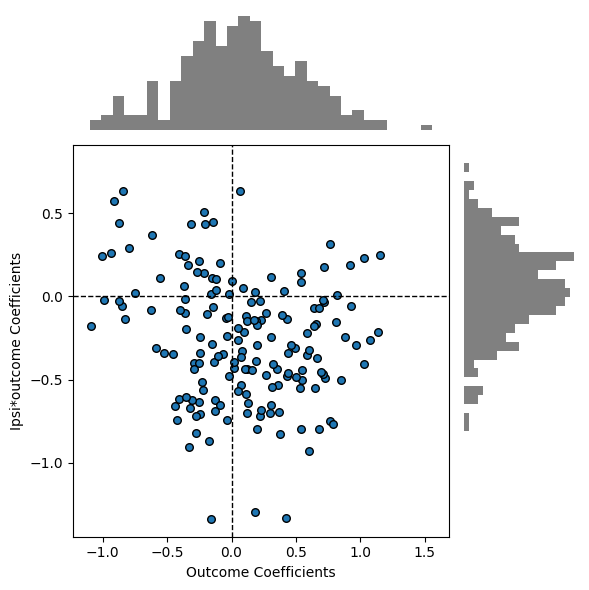

In [232]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'l'
verion = 'mc'  # 'ori' or 'mc'
c_or_t = 'T'
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)
if 'outcome:ipsi' in regressors_focus:
    curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
    curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 
else:
    curr_coefs_int = np.zeros(len(model_combined))
    curr_p_int = np.ones(len(model_combined))

curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

color_code = 'response_rate'
color_code_var = features_combined[color_code].values.astype(float)
color_top = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.85)
color_bottom = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.05)
color_code_var[color_code_var >= color_top] = color_top
color_code_var[color_code_var <= color_bottom] = color_bottom                                                                                                                               
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_coefs_outcome[filter], curr_coefs_q[filter], edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Ipsi*outcome Coefficients')
# plt.colorbar(im)

# Histogram for X-axis
ax_histx.hist(curr_coefs_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_coefs_int, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


In [233]:
thresh =0.05
all_vec = np.column_stack((curr_coefs_outcome[filter], curr_coefs_q[filter]))  # combine the coefficients for the reward outcome and Qchosen
all_vec = all_vec.astype(float)
# Convert Cartesian coordinates to polar coordinates
theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
bound_1 = -(1/4)*np.pi
bound_2 = np.pi
bound_3 = -np.pi
theta_scaled_dis  = np.full(len(theta), np.nan)
for ind, angle_curr in enumerate(theta):
    if bound_1 < angle_curr <= bound_2:
        theta_scaled_dis[ind] = (angle_curr-bound_1)/(bound_2-bound_1)
    else:
        theta_scaled_dis[ind] = (bound_1-angle_curr)/(bound_1-bound_3)
theta_scaled_dis_all = np.full(len(features_combined), np.nan)
theta_scaled_dis_all[filter] = theta_scaled_dis
features_combined['theta_scaled_dis'] = theta_scaled_dis_all

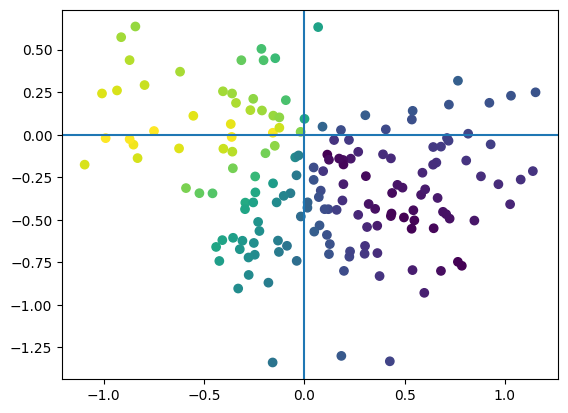

In [234]:
plt.scatter(curr_coefs_outcome[filter], curr_coefs_q[filter], c=theta_scaled_dis)
plt.axhline(0)
plt.axvline(0)

KeyError: 'respose_ratio'

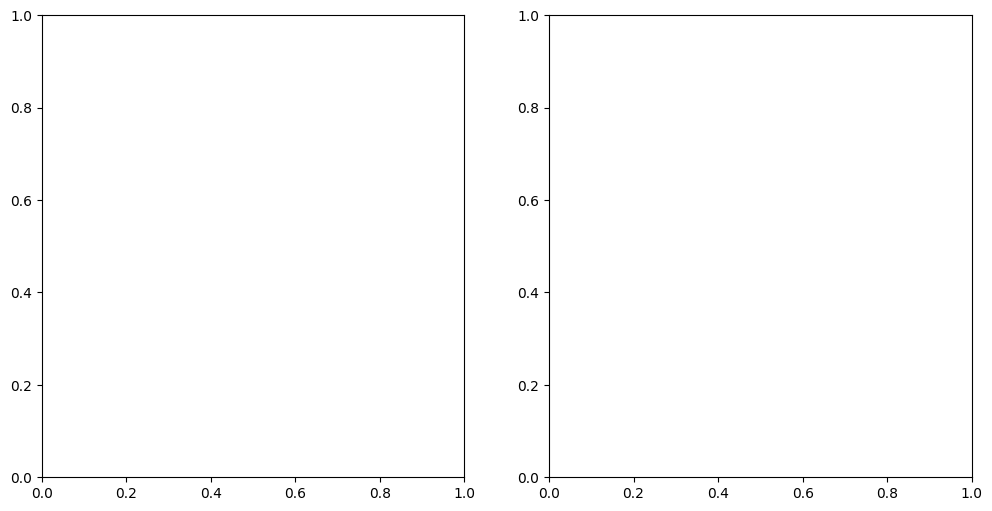

In [240]:
from scipy.stats import t, pearsonr
from sklearn.linear_model import LinearRegression
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
x_label = 'respose_ratio' #'response_rate' 
y_label = 'theta'
color_code = 'pc_1'
num_bins = 3
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['T_outcome_com_mc'].values <= 30)
nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# bin_edges = np.linspace(np.nanmin(features_combined[x_label].values[filter]), np.nanmax(features_combined[x_label].values[filter]), num_bins+1)
# # bin_edges = np.quantile(features_combined[x_label].values[filter][~nan_mask], np.linspace(0, 1, num_bins+1))
# mean_x = np.zeros(num_bins)
# mean_y = np.zeros(num_bins)
# se_y = np.zeros(num_bins)

# for i in range(num_bins):
#     bin_mask = (features_combined[x_label].values[filter] >= bin_edges[i]) & (features_combined[x_label].values[filter] < bin_edges[i+1])
#     mean_x[i] = np.nanmean(features_combined[x_label].values[filter][bin_mask])
#     mean_y[i] = np.nanmean(features_combined[y_label].values[filter][bin_mask])
#     se_y[i] = stats.sem(features_combined[y_label].values[filter][bin_mask], nan_policy='omit')
# fit a regression line and add it to the plot
# Reshape for sklearn
x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)

X = x_vals.reshape(-1, 1)

# Fit model
lm = LinearRegression()
lm.fit(X, y_vals)
y_pred = lm.predict(X)

# Calculate residuals and standard error
residuals = y_vals - y_pred
dof = len(x_vals) - 2  # degrees of freedom
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

# Confidence interval (95%)
t_val = t.ppf(0.975, dof)

# Prediction standard error at each x
se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

# Upper and lower CI
y_upper = y_pred + t_val * se_pred
y_lower = y_pred - t_val * se_pred

# Sort for nice line plot
sorted_idx = np.argsort(x_vals)
x_sorted = x_vals[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_upper_sorted = y_upper[sorted_idx]
y_lower_sorted = y_lower[sorted_idx]

# Plot regression line
axes[0].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# Plot confidence band
axes[0].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')


# Plot regression line
axes[1].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# Plot confidence band
axes[1].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')



color_code_values = features_combined[color_code].values[filter].astype(float)
color_code_5 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.01)
color_code_95 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.90)
color_code_values[color_code_values>=color_code_95]=color_code_95
color_code_values[color_code_values<=color_code_5]=color_code_5
im = axes[0].scatter(features_combined[x_label].values[filter], features_combined[y_label].values[filter], c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
axes[0].set_xlabel(x_label)
axes[0].set_ylabel(y_label)
plt.colorbar(im, label=color_code)
# axes[0].errorbar(mean_x, mean_y, yerr=se_y, fmt='-o', color='k', label='Mean with SE')
corr, p = pearsonr(features_combined[x_label].values[filter][~nan_mask].astype(float), features_combined[y_label].values[filter][~nan_mask].astype(float))
axes[0].set_title(f'Correlation: {corr:.2f} p-value: {p:.5f}')


im = axes[1].scatter(features_combined[x_label].values[filter], features_combined[y_label].values[filter], c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel(y_label)
plt.colorbar(im, label=color_code)

# # anti cells
# anti_thresh = 2
# filter_anti = features_combined_anti['be_filter'].values
# filter_anti = np.array(filter_anti, dtype=bool)
# filter_anti = filter_anti & (features_combined_anti['anti_resp'].values <= anti_thresh) & (features_combined_anti['anti_resp'].values >= 1)
# nan_mask = features_combined_anti[filter_anti][x_label].isnull() | features_combined_anti[filter_anti][y_label].isnull()
# # x_vals = features_combined_anti[x_label].values[filter][~nan_mask].astype(float)
# # y_vals = features_combined_anti[y_label].values[filter][~nan_mask].astype(float)

# axes[1].scatter(features_combined_anti[x_label].values[filter_anti], features_combined_anti[y_label].values[filter_anti], color = 'r', alpha = 0.8, edgecolors='none', s = 100, linewidths=2)

fig.savefig(fname=os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.svg'), bbox_inches='tight')

In [ ]:
os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.pdf')

'/root/capsule/scratch/combined/beh_plots/basic_ephys_anti/T_outcome_com_mc_vs_response_diff_color_pc_1_basic_ephys_anti.pdf'

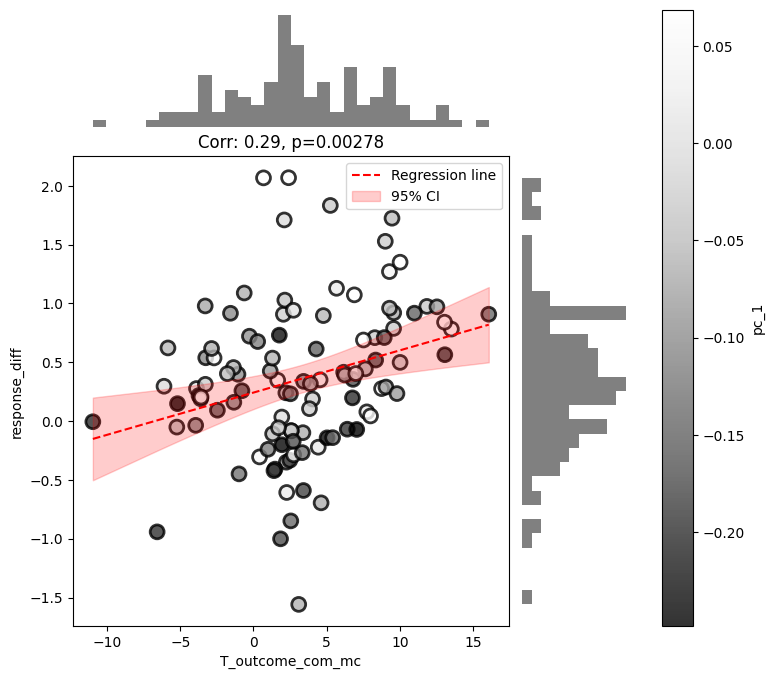

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import t, pearsonr
from sklearn.linear_model import LinearRegression
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
# filter = filter & (features_combined['bl_mean'].values >= 2)
nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# Extract data
x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)
color_vals = features_combined[color_code].values[filter][~nan_mask].astype(float)

# Clip color range for better visualization
color_code_5 = np.nanquantile(color_vals, 0.01)
color_code_95 = np.nanquantile(color_vals, 0.90)
color_vals = np.clip(color_vals, color_code_5, color_code_95)

# Fit regression
X = x_vals.reshape(-1, 1)
lm = LinearRegression().fit(X, y_vals)
y_pred = lm.predict(X)

# Confidence interval
residuals = y_vals - y_pred
dof = len(x_vals) - 2
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)
t_val = t.ppf(0.975, dof)
se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

y_upper = y_pred + t_val * se_pred
y_lower = y_pred - t_val * se_pred

# Sort for smooth CI band
sorted_idx = np.argsort(x_vals)
x_sorted = x_vals[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_upper_sorted = y_upper[sorted_idx]
y_lower_sorted = y_lower[sorted_idx]

# Create figure with gridspec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.1, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1, 0])
sc = ax_main.scatter(x_vals, y_vals, c=color_vals, cmap='Greys_r', s=100, edgecolors='k', linewidths=2, alpha=0.8)
ax_main.plot(x_sorted, y_pred_sorted, 'r--', label='Regression line')
ax_main.fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')
ax_main.set_xlabel(x_label)
ax_main.set_ylabel(y_label)
corr, p = pearsonr(x_vals, y_vals)
ax_main.set_title(f'Corr: {corr:.2f}, p={p:.5f}')
ax_main.legend()

# Histogram on top (X axis)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_histx.hist(x_vals, bins=30, color='gray')
ax_histx.axis('off')

# Histogram on right (Y axis)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_histy.hist(y_vals, bins=30, orientation='horizontal', color='gray')
ax_histy.axis('off')

# Colorbar
cbar = fig.colorbar(sc, ax=[ax_main, ax_histx, ax_histy], orientation='vertical', fraction=0.05)
cbar.set_label(color_code)

# Save
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}_marginal_hist.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}_marginal_hist.svg'), bbox_inches='tight')

plt.show()


NameError: name 'features_combined_anti' is not defined

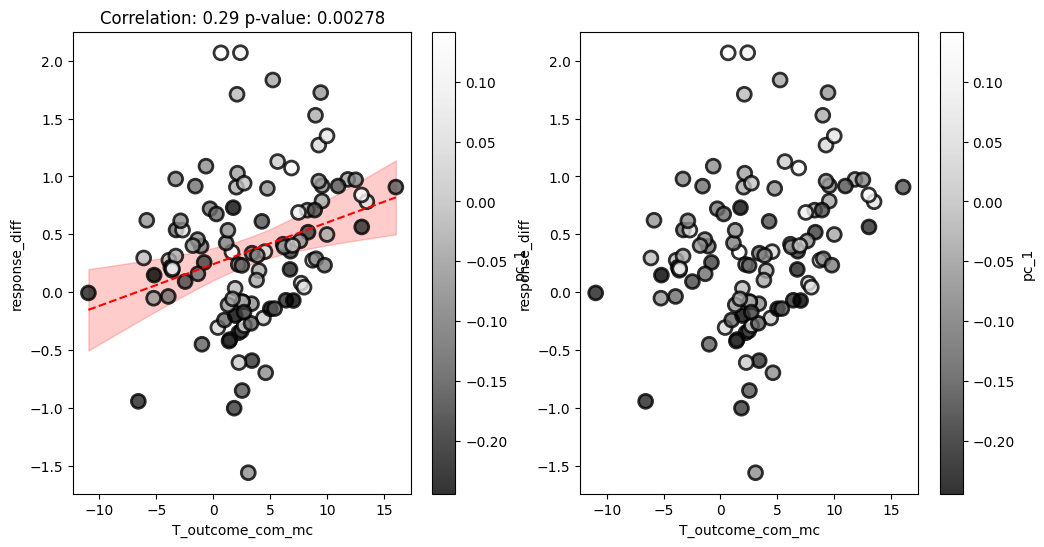

In [ ]:
from scipy.stats import t, pearsonr
from sklearn.linear_model import LinearRegression
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
x_label = 'T_outcome_com_mc' #'response_rate' 
y_label = 'response_diff'
color_code = 'pc_1'
num_bins = 3
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
# filter = filter & (features_combined['bl_mean'].values >= 2)
nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# bin_edges = np.linspace(np.nanmin(features_combined[x_label].values[filter]), np.nanmax(features_combined[x_label].values[filter]), num_bins+1)
# # bin_edges = np.quantile(features_combined[x_label].values[filter][~nan_mask], np.linspace(0, 1, num_bins+1))
# mean_x = np.zeros(num_bins)
# mean_y = np.zeros(num_bins)
# se_y = np.zeros(num_bins)

# for i in range(num_bins):
#     bin_mask = (features_combined[x_label].values[filter] >= bin_edges[i]) & (features_combined[x_label].values[filter] < bin_edges[i+1])
#     mean_x[i] = np.nanmean(features_combined[x_label].values[filter][bin_mask])
#     mean_y[i] = np.nanmean(features_combined[y_label].values[filter][bin_mask])
#     se_y[i] = stats.sem(features_combined[y_label].values[filter][bin_mask], nan_policy='omit')
# fit a regression line and add it to the plot
# Reshape for sklearn
x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)

X = x_vals.reshape(-1, 1)

# Fit model
lm = LinearRegression()
lm.fit(X, y_vals)
y_pred = lm.predict(X)

# Calculate residuals and standard error
residuals = y_vals - y_pred
dof = len(x_vals) - 2  # degrees of freedom
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

# Confidence interval (95%)
t_val = t.ppf(0.975, dof)

# Prediction standard error at each x
se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

# Upper and lower CI
y_upper = y_pred + t_val * se_pred
y_lower = y_pred - t_val * se_pred

# Sort for nice line plot
sorted_idx = np.argsort(x_vals)
x_sorted = x_vals[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_upper_sorted = y_upper[sorted_idx]
y_lower_sorted = y_lower[sorted_idx]

# Plot regression line
axes[0].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# Plot confidence band
axes[0].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')


color_code_values = features_combined[color_code].values[filter].astype(float)
color_code_5 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.01)
color_code_95 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.90)
color_code_values[color_code_values>=color_code_95]=color_code_95
color_code_values[color_code_values<=color_code_5]=color_code_5
im = axes[0].scatter(features_combined[x_label].values[filter], features_combined[y_label].values[filter], c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
axes[0].set_xlabel(x_label)
axes[0].set_ylabel(y_label)
plt.colorbar(im, label=color_code)
# axes[0].errorbar(mean_x, mean_y, yerr=se_y, fmt='-o', color='k', label='Mean with SE')
corr, p = pearsonr(features_combined[x_label].values[filter][~nan_mask].astype(float), features_combined[y_label].values[filter][~nan_mask].astype(float))
axes[0].set_title(f'Correlation: {corr:.2f} p-value: {p:.5f}')


im = axes[1].scatter(features_combined[x_label].values[filter], features_combined[y_label].values[filter], c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel(y_label)
plt.colorbar(im, label=color_code)

# anti cells
anti_thresh = 2
filter_anti = features_combined_anti['be_filter'].values
filter_anti = np.array(filter_anti, dtype=bool)
filter_anti = filter_anti & (features_combined_anti['anti_resp'].values <= anti_thresh) & (features_combined_anti['anti_resp'].values >= 1)
nan_mask = features_combined_anti[filter_anti][x_label].isnull() | features_combined_anti[filter_anti][y_label].isnull()
x_vals = features_combined_anti[x_label].values[filter][~nan_mask].astype(float)
y_vals = features_combined_anti[y_label].values[filter][~nan_mask].astype(float)

axes[1].scatter(features_combined_anti[x_label].values[filter_anti], features_combined_anti[y_label].values[filter_anti], color = 'r', alpha = 0.8, edgecolors='none', s = 100, linewidths=2)

fig.savefig(fname=os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.svg'), bbox_inches='tight')

Text(0.5, 1.0, 'base-response crosscorrelation')

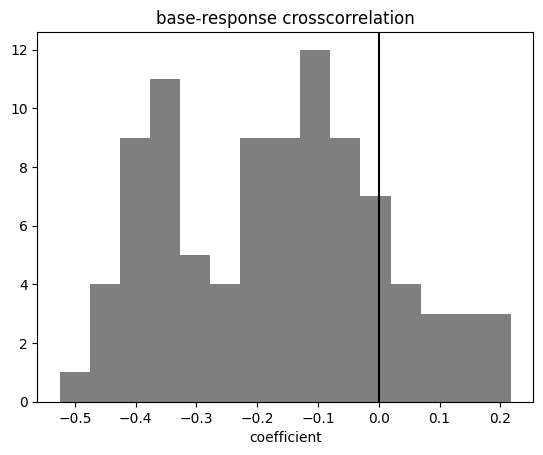

In [ ]:
plt.hist(features_combined['bl_response_corr'][filter], 15, alpha = 0.5, facecolor = 'k', edgecolor = 'none')
plt.axvline(0, color = 'k')
plt.xlabel('coefficient')
plt.title('base-response crosscorrelation')

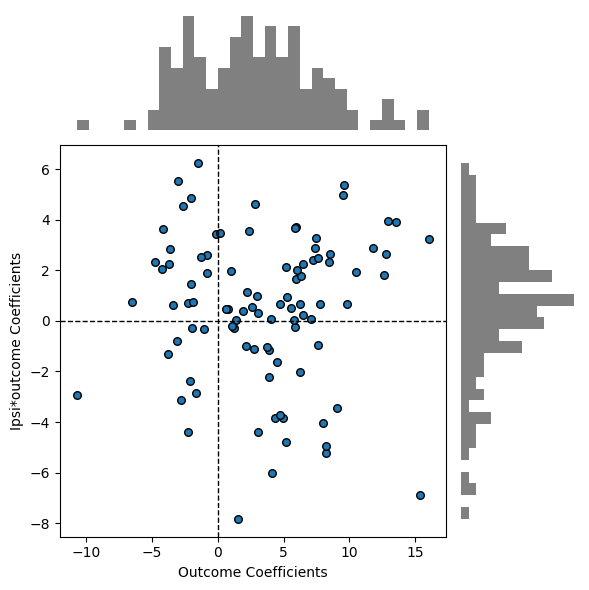

In [ ]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'com'
verion = 'mc'  # 'ori' or 'mc'
c_or_t = 'T'
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)
if 'outcome:ipsi' in regressors_focus:
    curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
    curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 
    curr_T_int = features_combined[f'T_outcome:ipsi_{period}_{verion}'].values 
else:
    curr_coefs_int = np.zeros(len(model_combined))
    curr_p_int = np.ones(len(model_combined))

curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

color_code = 'response_rate'
color_code_var = features_combined[color_code].values.astype(float)
color_top = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.85)
color_bottom = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.05)
color_code_var[color_code_var >= color_top] = color_top
color_code_var[color_code_var <= color_bottom] = color_bottom                                                                                                                               
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_T_outcome[filter], curr_T_int[filter], edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Ipsi*outcome Coefficients')
plt.colorbar(im)

# Histogram for X-axis
ax_histx.hist(curr_T_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_T_int, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


# Compare with old data

In [ ]:
# load matlab data
lm_data = loadmat('/root/capsule/scratch/combined/fromMatlab/aucWinLM.mat')
allTStats_old = lm_data['tStatsMax']
allCoefs_old = lm_data['coeffsMax']
allPs_old = lm_data['psMax']
outcomeInd = 0
qInd = 1
outcome_T_old = allTStats_old[:, outcomeInd]
qchosen_T_old = allTStats_old[:, qInd]
outcome_coef_old = allCoefs_old[:, outcomeInd]
qchosen_coef_old = allCoefs_old[:, qInd]

outcome_P_old = allPs_old[:, outcomeInd]

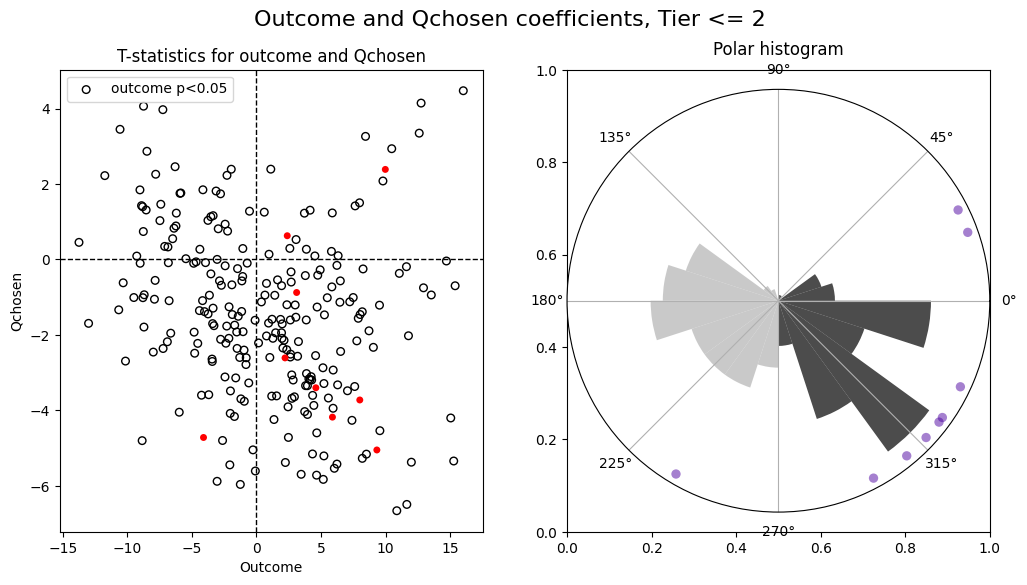

In [ ]:
anti_thresh = 2
period = 'com'
verion = 'mc'  # 'ori' or 'mc'
c_or_t = 'T'
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

filter_anti = features_combined_anti['be_filter'].values
filter_anti = np.array(filter_anti, dtype=bool)
filter_anti = filter_anti & (features_combined_anti['bl_mean'].values >= 2) #& (~features_combined_anti['response_diff'].isnull())
curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 
curr_T_int = features_combined[f'T_outcome:ipsi_{period}_{verion}'].values 

curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values[filter]
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values[filter]

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values[filter]  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values[filter]  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values[filter]  # get the p-values for the reward outcome
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
outcome_T_all = np.concatenate((curr_T_outcome, outcome_T_old))
qchosen_T_all = np.concatenate((curr_T_q, qchosen_T_old))
outcome_coef_all = np.concatenate((curr_coefs_outcome, outcome_coef_old))
qchosen_coef_all = np.concatenate((curr_coefs_q, qchosen_coef_old))
outcome_P_all = np.concatenate((curr_p_outcome, outcome_P_old))
thresh = 2
axes[0].scatter(outcome_T_all[outcome_P_all<thresh], qchosen_T_all[outcome_P_all<thresh], color='none', edgecolors='k', s=30, label = 'outcome p<0.05')
# axes[0].scatter(outcome_T_all[outcome_P_all>=thresh], qchosen_T_all[curr_p_outcome>=thresh], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# polar
edges = np.linspace(-np.pi, np.pi, 4*5+1)
axes[1] = fig.add_subplot(122, polar=True)
all_vec = np.column_stack((outcome_coef_all[outcome_P_all<thresh], qchosen_coef_all[outcome_P_all<thresh]))  # combine the coefficients for the reward outcome and Qchosen
# Convert Cartesian coordinates to polar coordinates
cat_mask = outcome_coef_all[outcome_P_all<thresh]>0
# Create polar histogram
# positive
theta, rho = np.arctan2(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0]), np.hypot(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0])
axes[1].hist(theta, bins=edges, color=[0.7, 0.7, 0.7], alpha=0.7, edgecolor='none', density=True)
# negative
theta, rho = np.arctan2(all_vec[cat_mask, 1], all_vec[cat_mask, 0]), np.hypot(all_vec[cat_mask, 1], all_vec[cat_mask, 0])
axes[1].hist(theta, bins=edges, color=[0, 0, 0], alpha=0.7, edgecolor='none', density=True)
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
# antidromic ones:
mask = (features_combined_anti['anti_resp'] <= anti_thresh) & (features_combined_anti['anti_resp']>0)
curr_coefs_outcome_anti = features_combined_anti[f'coef_outcome_{period}_{verion}'].values
curr_T_outcome_anti = features_combined_anti[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_coefs_q_anti = features_combined_anti[f'coef_Qchosen_{period}_{verion}'].values
curr_T_q_anti = features_combined_anti[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
new_vec_anti = np.column_stack((curr_coefs_outcome_anti, curr_coefs_q_anti))  # combine the coefficients for the reward outcome and Qchosen
theta, rho = np.arctan2(new_vec_anti[mask & filter_anti, 1], new_vec_anti[mask & filter_anti, 0]), np.hypot(new_vec_anti[mask & filter_anti, 1], new_vec_anti[mask & filter_anti, 0])
axes[1].scatter(theta, 0.9 * np.ones_like(theta), color=(76/255, 2/255, 161/255), alpha=0.5, edgecolors='none', s=45)
# axes[1].hist(theta, bins=edges, color='red', alpha=0.7, edgecolor='none', density=True)
axes[0].scatter(curr_T_outcome_anti[filter_anti & mask], curr_T_q_anti[filter_anti & mask], color='r', edgecolors='none', s=25, label='anti cells')
# set box and axis to be invisible
# axes[1].get_xaxis().set_visible(False)
# axes[1].get_yaxis().set_visible(False)
plt.suptitle(f'Outcome and Qchosen coefficients, Tier <= {anti_thresh}', fontsize=16)
plt.savefig(os.path.join(beh_folder, f'Combined_Summary_outcome_Qchosen_coeffs_{criteria_name}_with_anti_at_{anti_thresh}.pdf'), bbox_inches='tight')